In [249]:
import sklearn as sk
from sklearn import linear_model
import pandas as pd
import numpy as np

In [250]:
X = pd.read_csv('data/preprocessing/X.csv')
y = pd.read_csv('data/preprocessing/y.csv')

In [251]:
size = y.shape[0]
mu = 0
sigma = 1e-6
noise = np.random.normal(mu,sigma,size)

In [252]:
y['noise'] = y['email_time_center'] + sigma

In [253]:
y[y['noise'] == 0]

,email_time_center,noise


array([[<Axes: title={'center': 'email_time_center'}>,
        <Axes: title={'center': 'noise'}>]], dtype=object)

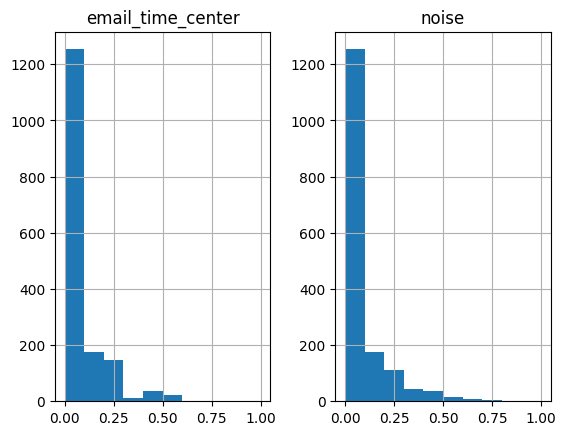

In [254]:
y.hist()

In [255]:
from sklearn.model_selection import train_test_split

In [256]:
X_train, X_test, y_train, y_test = train_test_split(X, y['noise'], test_size=0.2, random_state=42)

In [257]:
print(X_train.shape)
print(y_train.shape)

(1319, 28)
(1319,)


<Axes: >

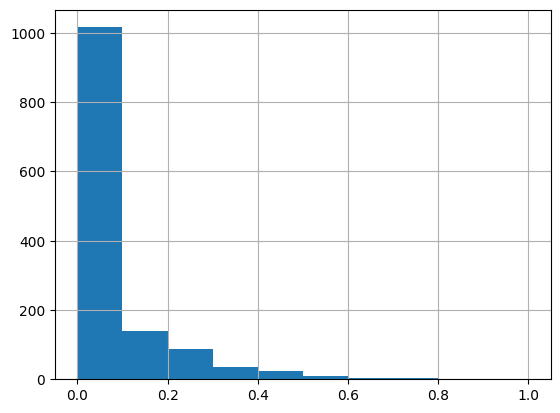

In [258]:
y_train.hist()

<Axes: >

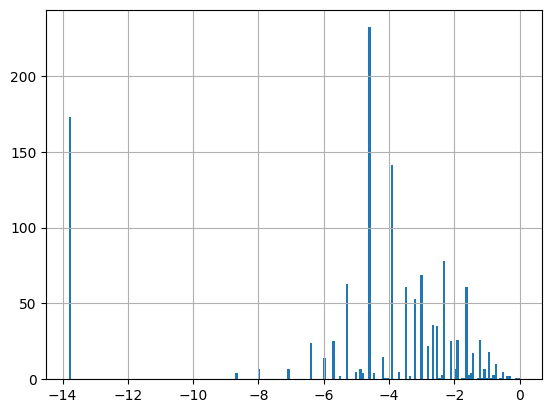

In [259]:
y_train_log = np.log(y_train)
y_train_log.hist(bins=200)

In [260]:
clf = linear_model.GammaRegressor()
clf.fit(X_train, y_train)

GammaRegressor()

In [261]:
y_pred = clf.predict(X_test)

<Axes: >

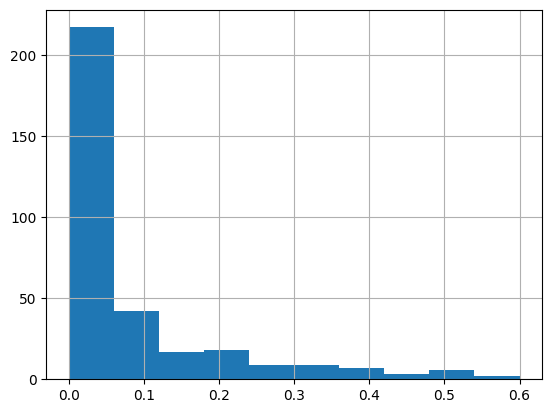

In [262]:
y_test.hist()

<Axes: >

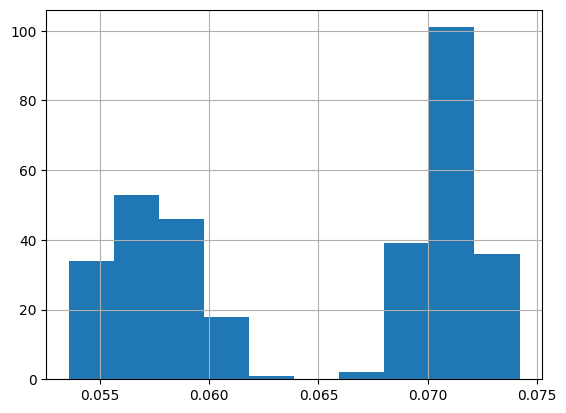

In [263]:
pd.Series(y_pred).hist()

In [264]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_test, y_pred)

0.01420051544314026

In [265]:
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

In [266]:
y_test_log.shape

(330,)

In [267]:
y

,email_time_center,noise
0,0.120000,0.120001
1,0.005000,0.005001
2,0.001667,0.001668
3,0.020000,0.020001
4,0.400000,0.400001
...,...,...
1644,0.010000,0.010001
1645,0.200000,0.200001
1646,0.020000,0.020001
1647,0.000000,0.000001


In [268]:
from sklearn.linear_model import ElasticNet

regr = ElasticNet(random_state=0)
regr.fit(X_train, y_train_log)

ElasticNet(random_state=0)

In [269]:
y_pred = np.exp(regr.predict(X_test))

mean_squared_error(y_test, y_pred)

0.019634845472408

In [271]:
y_train_log_ = np.reshape(y_train_log, (-1,1))

In [275]:
classified_y = [True if x>-10 else False for x in y_train_log]

In [276]:
X_train['Filter'] = classified_y

In [291]:
X_train_ = X_train[X_train['Filter']==True]
X_train_ = X_train_.drop(columns=['Filter'],axis=1)
X_train_

,educ_center,harass5_Does not apply (i do not have a job/superior/co-worker),harass5_No,harass5_Yes,polviews_Conservative,polviews_Extremely liberal,polviews_Extrmly conservative,polviews_Liberal,polviews_Moderate,polviews_Slghtly conservative,...,instagrm_No,instagrm_Yes,wrkstat_Keeping house,wrkstat_Other,wrkstat_Retired,wrkstat_School,wrkstat_Temp not working,"wrkstat_Unempl, laid off",wrkstat_Working fulltime,wrkstat_Working parttime
584,1.000000,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,1,0,0,0
63,0.555556,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
1182,0.611111,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1640,0.722222,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,1,0,0,0,0
1466,0.722222,0,1,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130,0.611111,0,1,0,0,0,0,0,1,0,...,1,0,0,1,0,0,0,0,0,0
1294,0.777778,1,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
860,0.500000,0,1,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,1,0
1459,0.000000,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [294]:
y_train_log_ = np.reshape(y_train_log.loc[lambda x : x >- 10],(-1,1))
y_train_log_.shape

(1146, 1)

In [313]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=4, random_state=0).fit(y_train_log_)
classified_y = gm.predict(y_train_log_)
classified_y

array([1, 3, 2, ..., 1, 0, 3], dtype=int64)

In [296]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.sm_exceptions import ConvergenceWarning

In [ ]:
X_train_ = X_train_[['educ_center','harass5_Does not apply (i do not have a job/superior/co-worker)','harass5_No','harass5_Yes','polviews_Conservative','polviews_Extremely liberal','']]

In [314]:
md = sm.MixedLM(y_train_log_, X_train_, groups=classified_y)
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

                                         Mixed Linear Model Regression Results
Model:                                    MixedLM                       Dependent Variable:                       y     
No. Observations:                         1146                          Method:                                   REML  
No. Groups:                               4                             Scale:                                    0.2604
Min. group size:                          81                            Log-Likelihood:                           inf   
Max. group size:                          541                           Converged:                                Yes   
Mean group size:                          286.5                                                                         
------------------------------------------------------------------------------------------------------------------------
                                                                Coef.    S

In [ ]:
X_test['Interp']=1

In [315]:
y_pred = np.exp(mdf.predict(X_test))

mean_squared_error(y_test, y_pred)

0.023589366359775103

<Axes: >

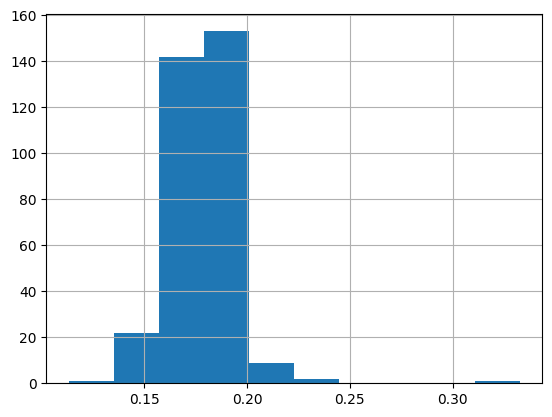

In [316]:
y_pred.hist()

<Axes: >

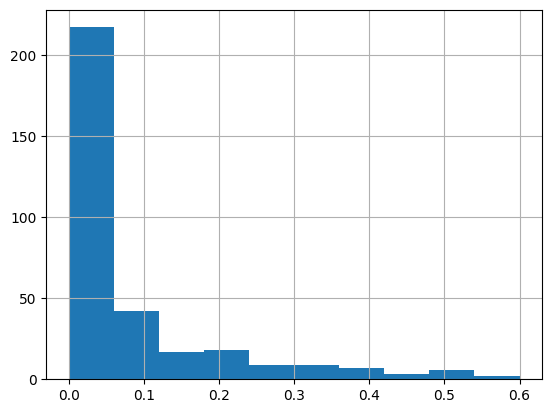

In [317]:
y_test.hist()